Step 1
- Load the data 
- inspect the data
- Clean up the data from outliers
- create a method to calculate the throuput and avergare out the user

Imports and statics

In [21]:
from pandas import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import numpy as np

MOVEMENT_TIME_THRESHOLD = 10
NON_SUSPICIOUS_MOVEMENT_TIME_THRESHOLD = 3


Functions

In [22]:
# Keep only the first entry for each user
def keep_first_entry_per_user(dataframe):
    return dataframe[~dataframe['uuid'].duplicated(keep='first')].reset_index(drop=True)


# Remove the first entry for each user
def remove_first_entry_per_user(dataframe):
    drop_indices = []
    seen = set()
    
    for index, row in dataframe.iterrows():
        uuid = row['uuid']
        if uuid in seen:
            continue
        drop_indices.append(index)
        seen.add(uuid)
        
    return dataframe.drop(index=drop_indices).reset_index(drop=True)


# Remove entries with movement_time higher than threshold
def remove_high_mt_outliers(dataframe, threshold):
    return dataframe[dataframe['movement_time'] <= threshold]


# Get entries with suspiciously high movement times
def get_suspicious_movement_times(dataframe):
    suspicious_uuids = []
    
    for _ , row in dataframe.iterrows():
        if row['movement_time'] > NON_SUSPICIOUS_MOVEMENT_TIME_THRESHOLD:
            suspicious_uuids.append(row['uuid'])
    
    return dataframe[dataframe['uuid'].isin(suspicious_uuids)]

# Read data

In [23]:
FOLDER = 'data/'
FILE = 'data.csv'
df = pd.read_csv(FOLDER + FILE) 

In [24]:
df.sort_values('movement_time', ascending=False)

,uuid,user_age,device,computer_time,target_object_id,misses,movement_time,index_difficulty
774,f03cac9f-8548-43aa-a2b9-de0d4e3135f6,54,Mouse,10,21,2,35.063,2.996
506,fa2558fd-5af8-495d-9bd1-cc550f0964cb,22,Mouse,5,16,0,24.554,4.203
736,8218f964-9ddc-4369-885f-3851eddecee7,61,Mouse,1,13,0,7.676,2.659
392,71a9bf81-f720-4655-8f6f-4f6728e37dd2,26,Mouse,6,11,5,6.643,1.839
781,f03cac9f-8548-43aa-a2b9-de0d4e3135f6,54,Mouse,10,0,3,5.981,2.055
...,...,...,...,...,...,...,...,...
720,9ccf3d9b-909d-4dd4-857c-197fbb349584,23,Mouse,8,8,0,0.380,1.796
528,fa2558fd-5af8-495d-9bd1-cc550f0964cb,22,Mouse,5,20,0,0.375,1.275
723,9ccf3d9b-909d-4dd4-857c-197fbb349584,23,Mouse,8,3,0,0.367,1.346
728,9ccf3d9b-909d-4dd4-857c-197fbb349584,23,Mouse,8,7,0,0.363,2.449


In [25]:
# Create a DataFrame with only one entry per user
total_users_df = keep_first_entry_per_user(df).copy()
total_users_df = total_users_df.drop(columns=['target_object_id', 'misses', 'movement_time', 'index_difficulty'])
total_users_df.sort_values('computer_time', ascending=False)

,uuid,user_age,device,computer_time
38,9282e556-a1cb-4a86-9996-a85159479b96,25,Mouse,16
1,2efdf886-71a0-492f-9a1a-74f47b9f0ea1,25,Mouse,14
0,cd1842cb-4771-4c16-9de8-cc3e1bf66275,27,Trackpad,14
10,4d54afa4-9488-4087-b197-e3f9e781b14e,28,Mouse,14
21,9443b4dc-66a2-47a4-92a8-39ccd2bf4a36,25,Mouse,12
9,9ce933ac-17a3-4546-af21-5329a27ff930,24,Trackpad,11
35,1ed3368e-ee51-4eec-a627-feba6f4a91c8,57,Mouse,11
37,61ef5fd0-1dd0-4f0f-b023-5bd52d66557e,27,Mouse,10
33,f03cac9f-8548-43aa-a2b9-de0d4e3135f6,54,Mouse,10
34,4f1141fb-49fd-4309-a465-1de91a34c2c3,54,Mouse,10


In [26]:
# Create an index mapping for UUIDs to unique integers as strings
uuid_to_index = {uuid: str(i) for i, uuid in enumerate(df['uuid'].unique(), start=1)}

# Add a new column 'uuid_index' to the original DataFrame
df['uuid_index'] = df['uuid'].map(uuid_to_index)


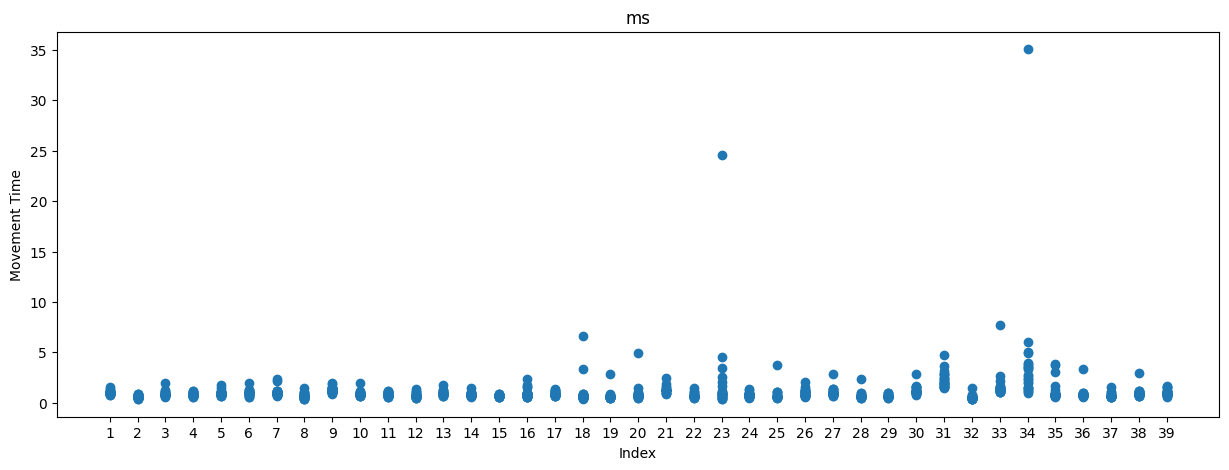

In [27]:
pyplot.figure(figsize=(15, 5))
pyplot.scatter(df['uuid_index'], df['movement_time'])
pyplot.xlabel('Index')
pyplot.ylabel('Movement Time')
pyplot.title('ms')
pyplot.show()

# Data cleanup

Removing the first click from useres

We remove the first entry from users because during testing, the timer calculating the clicking time started right after clicking Accept to the consent form, and no countdown was issued so many users were shocked they were instantly brought into testing.

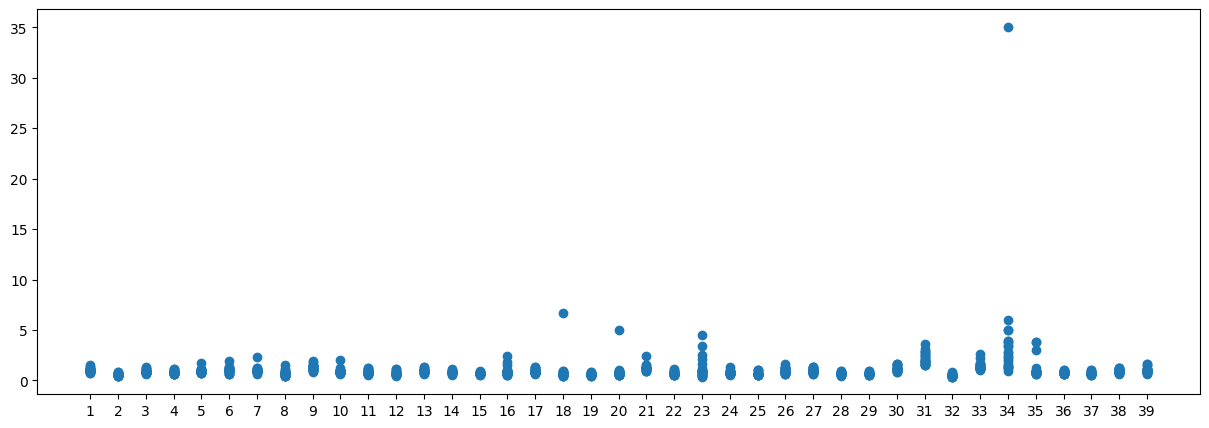

In [28]:
# Remove the first entry for every user
main_data = remove_first_entry_per_user(df).copy()
main_data.shape

pyplot.figure(figsize=(15, 5))
pyplot.scatter(main_data['uuid_index'], main_data['movement_time'])

In [29]:
columns_to_show = ['uuid', 'movement_time', 'target_object_id']
pd.concat([df[columns_to_show].head(25), main_data[columns_to_show].head(25)], axis=1)

,uuid,movement_time,target_object_id,uuid,movement_time,target_object_id
0,cd1842cb-4771-4c16-9de8-cc3e1bf66275,1.117,20,cd1842cb-4771-4c16-9de8-cc3e1bf66275,1.000,9
1,cd1842cb-4771-4c16-9de8-cc3e1bf66275,1.000,9,cd1842cb-4771-4c16-9de8-cc3e1bf66275,1.100,2
2,cd1842cb-4771-4c16-9de8-cc3e1bf66275,1.100,2,cd1842cb-4771-4c16-9de8-cc3e1bf66275,0.833,13
3,cd1842cb-4771-4c16-9de8-cc3e1bf66275,0.833,13,cd1842cb-4771-4c16-9de8-cc3e1bf66275,0.883,12
4,cd1842cb-4771-4c16-9de8-cc3e1bf66275,0.883,12,cd1842cb-4771-4c16-9de8-cc3e1bf66275,0.900,21
5,cd1842cb-4771-4c16-9de8-cc3e1bf66275,0.900,21,cd1842cb-4771-4c16-9de8-cc3e1bf66275,0.834,22
6,cd1842cb-4771-4c16-9de8-cc3e1bf66275,0.834,22,cd1842cb-4771-4c16-9de8-cc3e1bf66275,1.350,19
7,cd1842cb-4771-4c16-9de8-cc3e1bf66275,1.350,19,cd1842cb-4771-4c16-9de8-cc3e1bf66275,0.950,11
8,cd1842cb-4771-4c16-9de8-cc3e1bf66275,0.950,11,cd1842cb-4771-4c16-9de8-cc3e1bf66275,1.050,5
9,cd1842cb-4771-4c16-9de8-cc3e1bf66275,1.050,5,cd1842cb-4771-4c16-9de8-cc3e1bf66275,1.533,16


Removing the outliers

(857, 9)

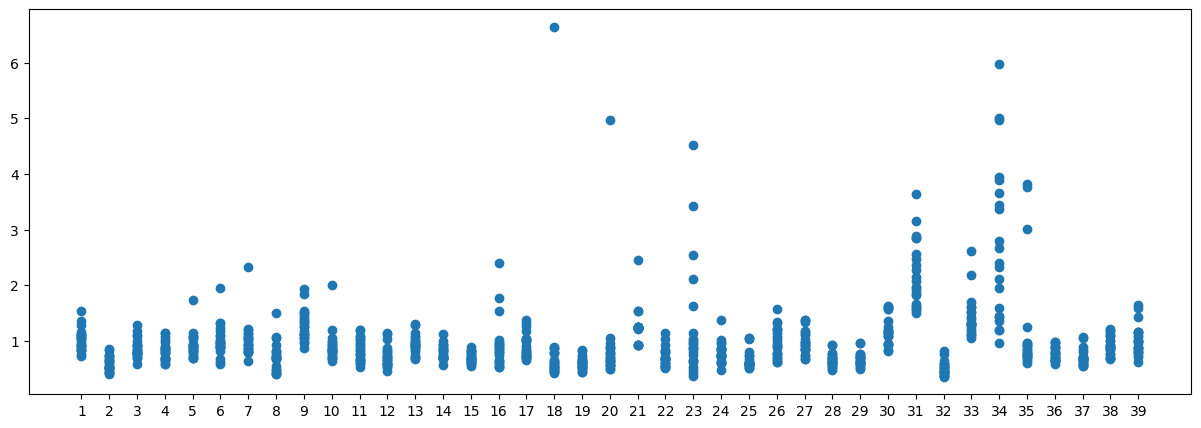

In [30]:
data_cleaned = remove_high_mt_outliers(main_data, MOVEMENT_TIME_THRESHOLD).copy()

pyplot.figure(figsize=(15, 5))
pyplot.scatter(data_cleaned['uuid_index'], data_cleaned['movement_time'])
data_cleaned.shape


Show the suspicious users who have high movement_time but was not their first data entry

(131, 9)

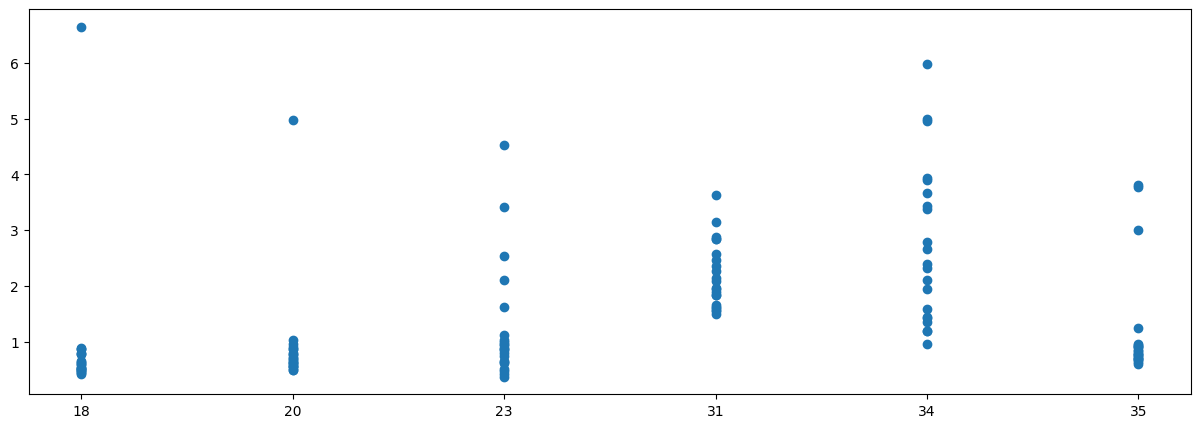

In [31]:
suspicious_uuids = get_suspicious_movement_times(data_cleaned)

pyplot.figure(figsize=(15, 5))
pyplot.scatter(suspicious_uuids['uuid_index'], suspicious_uuids['movement_time'])
suspicious_uuids.shape



# Added by Katrine and Jonas

## Data Information

Model only works on users with age from 19 to 76

And on daily computer hours between 1 to 16

The data is slightly skewed and gives weird results if the test includes numbers that aren't within our dataset range

In [32]:
# Calculate average movement_time per user and add as a new column in data_cleaned
data_cleaned['avg_movement_time'] = data_cleaned.groupby('uuid')['movement_time'].transform('mean')

# Check result
print(data_cleaned[['uuid', 'movement_time', 'avg_movement_time']].head(3))
print("\n")

# Define thresholds (example using quantiles)
q_low, q_high = data_cleaned['avg_movement_time'].quantile([0.33, 0.66])

def categorize_skill(mt):
    if mt <= q_low:
        return "Professional"
    elif mt <= q_high:
        return "Experienced"
    else:
        return "Inexperienced"

# Add skill category
data_cleaned['skill_category'] = data_cleaned['avg_movement_time'].apply(categorize_skill)

# Check
print(data_cleaned[['uuid', 'avg_movement_time', 'skill_category']].head(3))
print(f"\nCategorical values are {q_low:.2f} and {q_high:.2f}\n")

                                   uuid  movement_time  avg_movement_time
0  cd1842cb-4771-4c16-9de8-cc3e1bf66275          1.000           1.020455
1  cd1842cb-4771-4c16-9de8-cc3e1bf66275          1.100           1.020455
2  cd1842cb-4771-4c16-9de8-cc3e1bf66275          0.833           1.020455


                                   uuid  avg_movement_time skill_category
0  cd1842cb-4771-4c16-9de8-cc3e1bf66275           1.020455  Inexperienced
1  cd1842cb-4771-4c16-9de8-cc3e1bf66275           1.020455  Inexperienced
2  cd1842cb-4771-4c16-9de8-cc3e1bf66275           1.020455  Inexperienced

Categorical values are 0.78 and 0.97



## Model training

In [33]:
X = data_cleaned[["user_age", "computer_time", "device"]]
y = data_cleaned["skill_category"]

# Encode device
device_encoder = LabelEncoder()
X["device"] = device_encoder.fit_transform(X["device"])
# example: Mouse=1, Touchpad=0

# Encode target labels
skill_encoder = LabelEncoder()
y_encoded = skill_encoder.fit_transform(y)
# Professional=2, Experienced=1, Inexperienced=0 (example)


C:\Users\katri\AppData\Local\Temp\ipykernel_8188\3690369953.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["device"] = device_encoder.fit_transform(X["device"])


In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

svm = SVC(kernel="rbf", C=1.0, gamma="scale")
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=skill_encoder.classes_))

Accuracy: 0.686046511627907
               precision    recall  f1-score   support

  Experienced       0.93      0.41      0.57        69
Inexperienced       0.77      0.79      0.78        47
 Professional       0.56      0.95      0.71        56

     accuracy                           0.69       172
    macro avg       0.76      0.71      0.68       172
 weighted avg       0.77      0.69      0.67       172



In [35]:
def predict_user_skill(age, computer_time, device):
    # Put inputs into a dataframe-like structure
    user_input = pd.DataFrame([{
        "user_age": age,
        "computer_time": computer_time,
        "device": device
    }])
    
    # Encode device
    user_input["device"] = device_encoder.transform(user_input["device"])
    
    # Scale inputs
    user_scaled = scaler.transform(user_input)
    
    # Predict encoded label
    pred_encoded = svm.predict(user_scaled)[0]
    
    # Convert back to string label
    pred_label = skill_encoder.inverse_transform([pred_encoded])[0]
    
    return pred_label

## Results testing

Manual single result testing

In [36]:
# Manually test a result
AGE = 22
CT = 16
DEVICE = "Mouse"
result = predict_user_skill(age=AGE, computer_time=CT, device=DEVICE)
print("Predicted skill category:", result)

Predicted skill category: Inexperienced


Full notepad of every possible combination of inputs and outputs

In [37]:
# Testing results as text
results = []

for age in range(19, 77):
    for comp_time in range(1, 17):
        for device in ["Mouse", "Trackpad"]:
            
            pred = predict_user_skill(
                age=age,
                computer_time=comp_time,
                device=device
            )
            
            results.append((age, comp_time, device, pred))

# Example output
for r in results[:]:
    print(r)


(19, 1, 'Mouse', 'Professional')
(19, 1, 'Trackpad', 'Inexperienced')
(19, 2, 'Mouse', 'Professional')
(19, 2, 'Trackpad', 'Inexperienced')
(19, 3, 'Mouse', 'Professional')
(19, 3, 'Trackpad', 'Inexperienced')
(19, 4, 'Mouse', 'Professional')
(19, 4, 'Trackpad', 'Experienced')
(19, 5, 'Mouse', 'Professional')
(19, 5, 'Trackpad', 'Experienced')
(19, 6, 'Mouse', 'Professional')
(19, 6, 'Trackpad', 'Experienced')
(19, 7, 'Mouse', 'Professional')
(19, 7, 'Trackpad', 'Inexperienced')
(19, 8, 'Mouse', 'Professional')
(19, 8, 'Trackpad', 'Inexperienced')
(19, 9, 'Mouse', 'Professional')
(19, 9, 'Trackpad', 'Inexperienced')
(19, 10, 'Mouse', 'Professional')
(19, 10, 'Trackpad', 'Inexperienced')
(19, 11, 'Mouse', 'Professional')
(19, 11, 'Trackpad', 'Inexperienced')
(19, 12, 'Mouse', 'Professional')
(19, 12, 'Trackpad', 'Inexperienced')
(19, 13, 'Mouse', 'Professional')
(19, 13, 'Trackpad', 'Inexperienced')
(19, 14, 'Mouse', 'Professional')
(19, 14, 'Trackpad', 'Inexperienced')
(19, 15, 'Mouse'

Plotted heatmap results

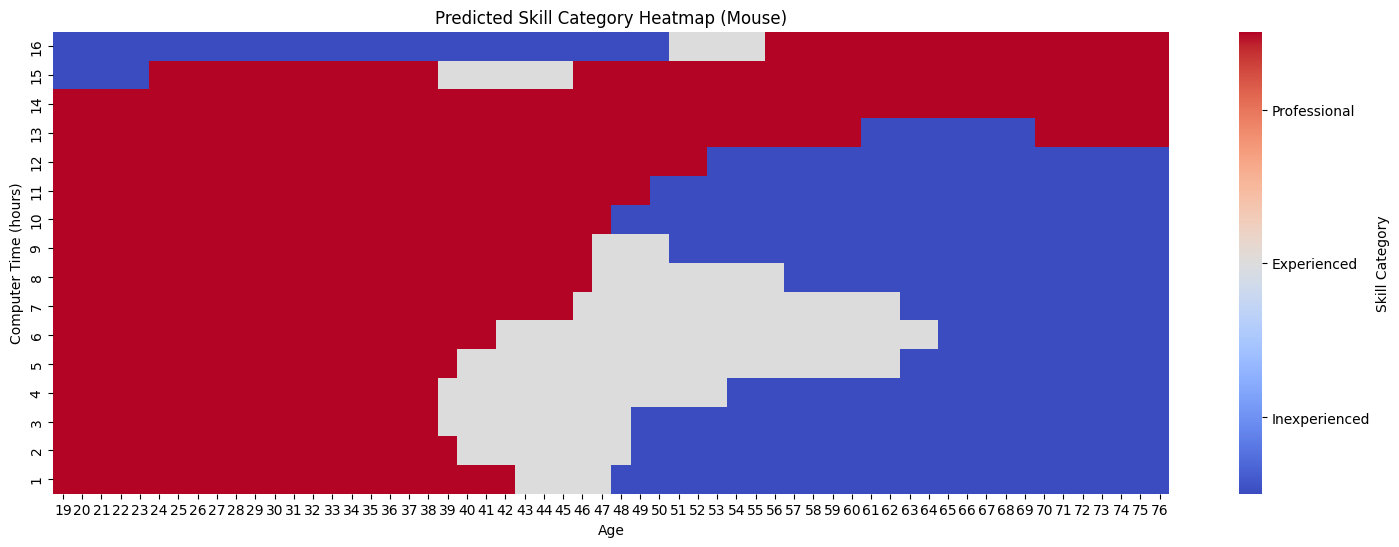

In [38]:
# Choose device
device_to_plot = "Mouse"

# Create matrix of predictions
ages = list(range(19, 77))
comp_times = list(range(1, 17))

heatmap_matrix = np.empty((len(comp_times), len(ages)), dtype=object)

for i, comp_time in enumerate(comp_times):
    for j, age in enumerate(ages):
        pred = predict_user_skill(age, comp_time, device_to_plot)
        heatmap_matrix[i, j] = pred

# Convert categories to numbers for coloring
categories = ["Inexperienced", "Experienced", "Professional"]
cat_to_num = {cat: idx for idx, cat in enumerate(categories)}
heatmap_numeric = np.vectorize(lambda x: cat_to_num[x])(heatmap_matrix)

# Plot
pyplot.figure(figsize=(18, 6))
sns.heatmap(
    heatmap_numeric,
    xticklabels=ages,
    yticklabels=comp_times,
    cmap="coolwarm",  # choose any colormap
    cbar_kws={'ticks': [0.33, 1, 1.66], 'label': 'Skill Category'}
)

# Set colorbar labels
colorbar = pyplot.gca().collections[0].colorbar
colorbar.set_ticklabels(categories)

pyplot.xlabel("Age")
pyplot.ylabel("Computer Time (hours)")
pyplot.title(f"Predicted Skill Category Heatmap ({device_to_plot})")
pyplot.gca().invert_yaxis()
pyplot.show()


`Our results are skewed and not great because we have daily hours instead of weekly and too small of a dataset`

## Testing multiple models

This section will be removed after review with Claus

In [39]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# List of models to test
models = {
    "SVM (RBF)": SVC(kernel="rbf", C=1.0, gamma="scale"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class="multinomial")
}

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Report
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=skill_encoder.classes_))
    print("\n")

--- SVM (RBF) ---
Accuracy: 0.686046511627907
               precision    recall  f1-score   support

  Experienced       0.93      0.41      0.57        69
Inexperienced       0.77      0.79      0.78        47
 Professional       0.56      0.95      0.71        56

     accuracy                           0.69       172
    macro avg       0.76      0.71      0.68       172
 weighted avg       0.77      0.69      0.67       172



--- Random Forest ---
Accuracy: 0.9127906976744186
               precision    recall  f1-score   support

  Experienced       1.00      0.86      0.92        69
Inexperienced       0.91      0.89      0.90        47
 Professional       0.84      1.00      0.91        56

     accuracy                           0.91       172
    macro avg       0.92      0.92      0.91       172
 weighted avg       0.92      0.91      0.91       172



--- Gradient Boosting ---
Accuracy: 0.9186046511627907
               precision    recall  f1-score   support

  Experience

c:\Users\katri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


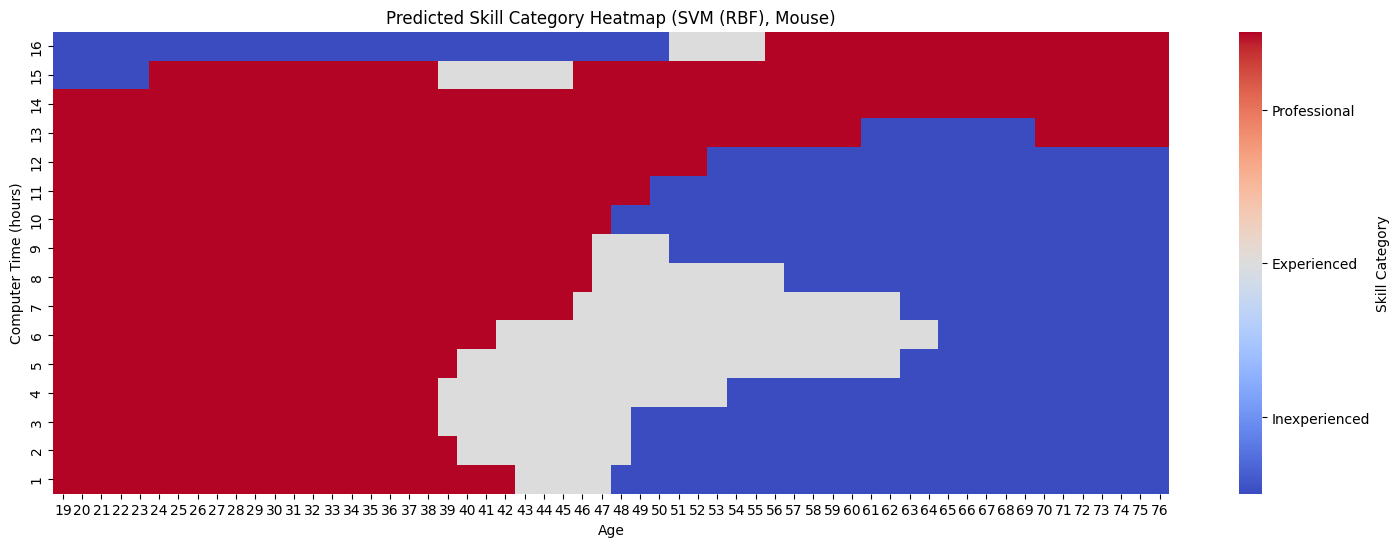

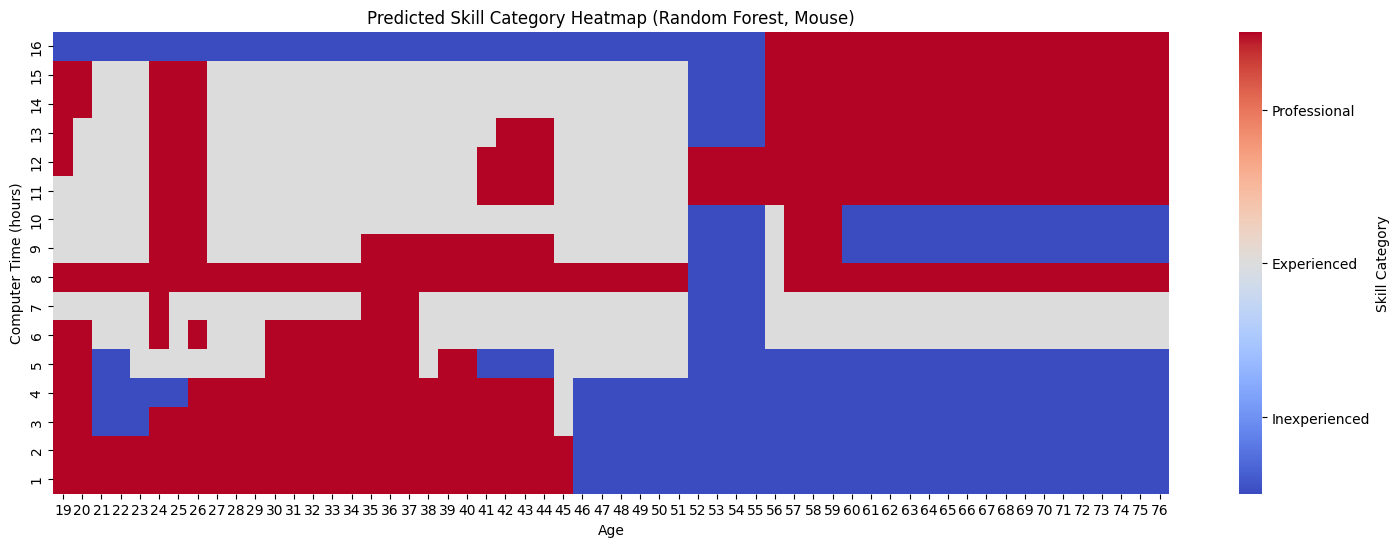

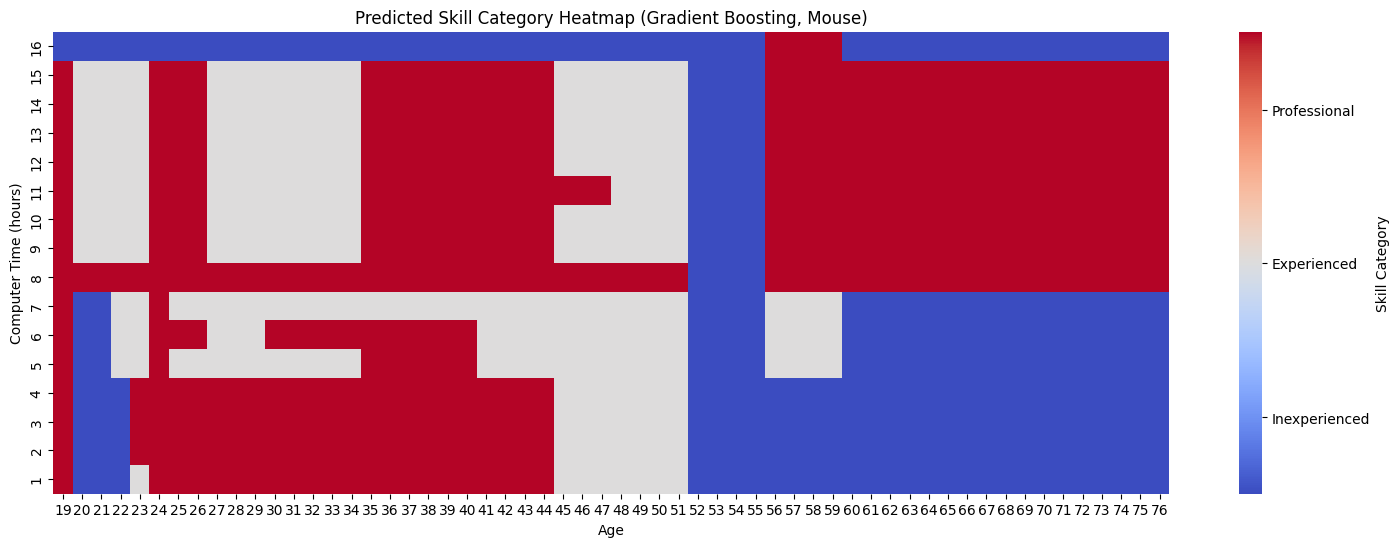

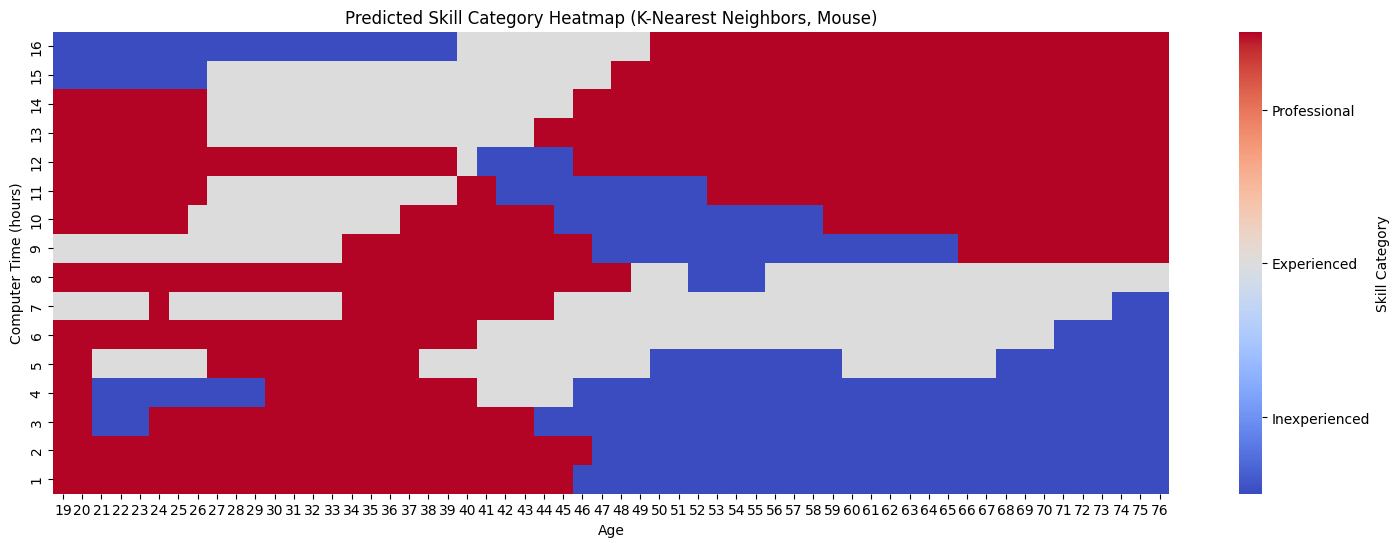

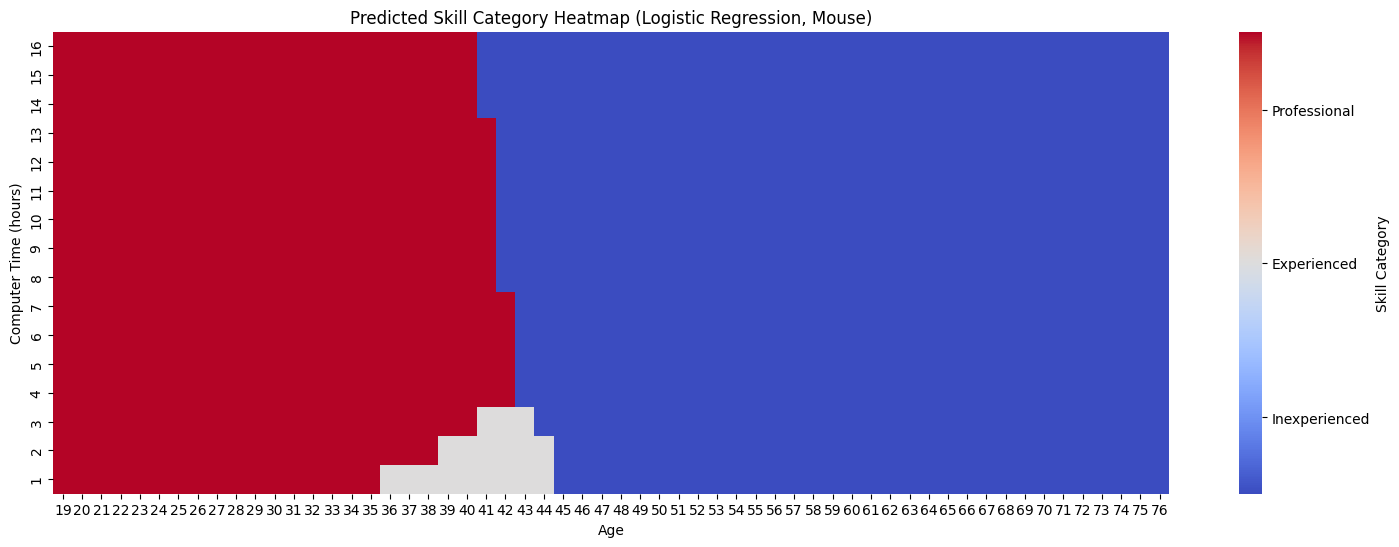

In [40]:
# Make a generalized prediction function
def predict_user_skill_model(model, age, computer_time, device):
    # Put inputs into a dataframe-like structure
    user_input = pd.DataFrame([{
        "user_age": age,
        "computer_time": computer_time,
        "device": device
    }])
    
    # Encode device
    user_input["device"] = device_encoder.transform(user_input["device"])
    
    # Scale inputs
    user_scaled = scaler.transform(user_input)
    
    # Predict encoded label
    pred_encoded = model.predict(user_scaled)[0]
    
    # Convert back to string label
    pred_label = skill_encoder.inverse_transform([pred_encoded])[0]
    
    return pred_label

# Device and ranges
device_to_plot = "Mouse"
ages = list(range(19, 77))
comp_times = list(range(1, 17))
categories = ["Inexperienced", "Experienced", "Professional"]
cat_to_num = {cat: idx for idx, cat in enumerate(categories)}

# Loop over all trained models
for name, model in models.items():
    heatmap_matrix = np.empty((len(comp_times), len(ages)), dtype=object)
    
    for i, comp_time in enumerate(comp_times):
        for j, age in enumerate(ages):
            heatmap_matrix[i, j] = predict_user_skill_model(model, age, comp_time, device_to_plot)
    
    # Convert to numeric for coloring
    heatmap_numeric = np.vectorize(lambda x: cat_to_num[x])(heatmap_matrix)
    
    # Plot
    pyplot.figure(figsize=(18, 6))
    sns.heatmap(
        heatmap_numeric,
        xticklabels=ages,
        yticklabels=comp_times,
        cmap="coolwarm",
        cbar_kws={'ticks': [0.33, 1, 1.66], 'label': 'Skill Category'}
    )
    
    colorbar = pyplot.gca().collections[0].colorbar
    colorbar.set_ticklabels(categories)
    
    pyplot.xlabel("Age")
    pyplot.ylabel("Computer Time (hours)")
    pyplot.title(f"Predicted Skill Category Heatmap ({name}, {device_to_plot})")
    pyplot.gca().invert_yaxis()
    pyplot.show()
